In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import math
import scipy.io as scio
import matplotlib
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline


In [134]:
def rmse(res_y, real_y):
    n = len(res_y)
    cnt = 0.0
    for i in range(n):
        cnt += (res_y[i] - real_y[i])**2
    cnt /= n
    return math.sqrt(cnt)

In [3]:
df = pd.read_csv('HisRawData_ForPower_Final.csv')

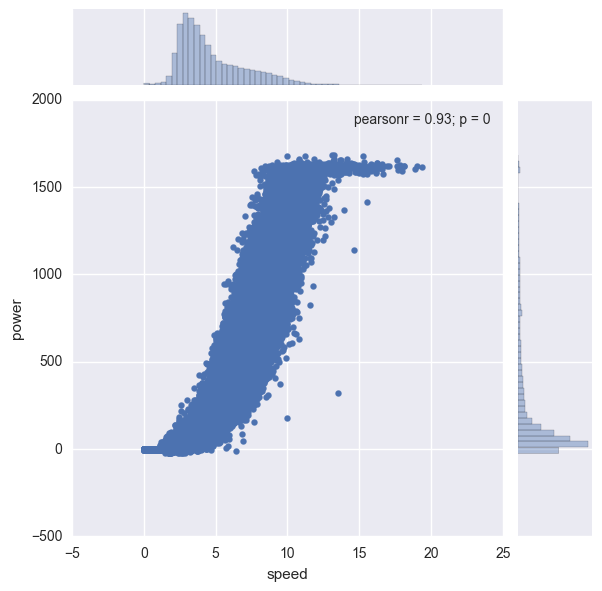

In [6]:
sns.jointplot(x = 'speed', y = 'power', data = df, linewidth=0.1)

In [7]:
df_valid = df[df['status']==11]
sum(df['status']==11)/len(df.index)

1.0

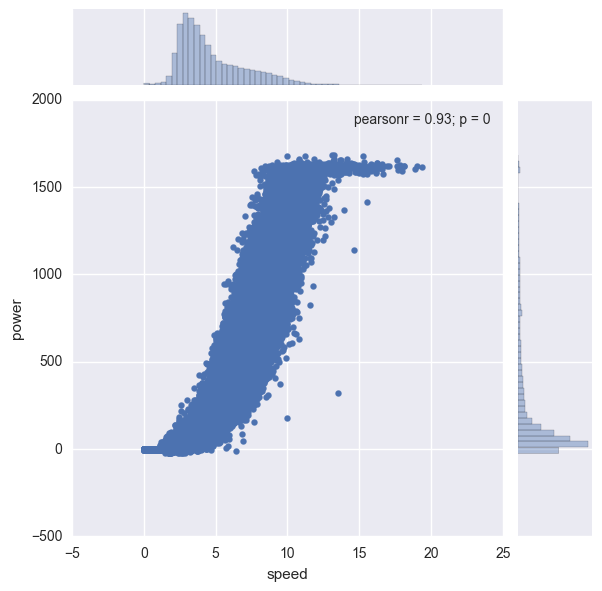

In [8]:
sns.jointplot(x = 'speed', y = 'power', data = df_valid, linewidth=0.1)

In [9]:
#删除power>1500的数据
print(sum(df_valid['power']>1500)/len(df_valid.index))
df_valid = df_valid[df_valid['power']<=1500]
#删除power<0的数据
print(sum(df_valid['power']<0)/len(df_valid.index))
df_valid = df_valid[df_valid['power']>=0]

0.012710051577
0.0251575355245


In [10]:
#df_valid['power'] = df_valid['power']**(1/3.0)

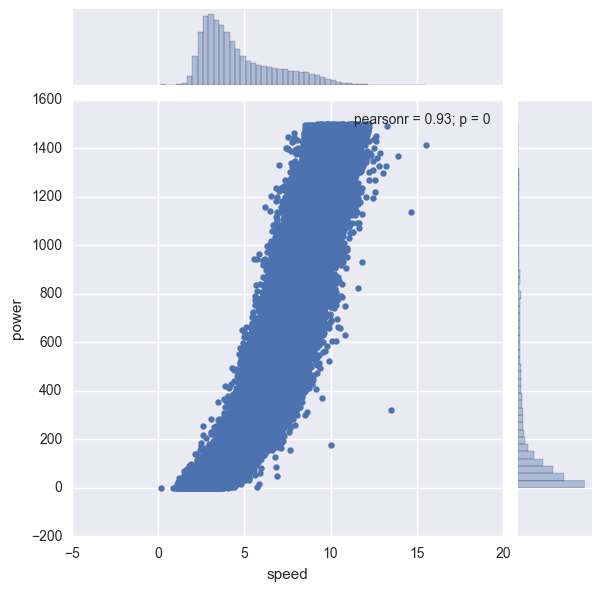

In [11]:
#plt.scatter(list(df_valid.speed), df_valid.power)
sns.jointplot(x = 'speed', y = 'power', data = df_valid,linewidth=0.1)

In [12]:
import re
not_july = []
t = list(df_valid['timestamp'])
for i in range(len(df_valid)):
    not_july.append(re.search(r'2016-07-',t[i]) is None)
#print(not_july)
X_train = pd.DataFrame(df_valid[not_july]['speed'])
y_train = df_valid[not_july]['power']
y_train3 = df_valid[not_july]['power']**(1/3.0)
X_july = pd.DataFrame(df_valid[np.logical_not(not_july)]['speed'])
y_test = df_valid[np.logical_not(not_july)]['power']

In [13]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoLars, LassoCV, LassoLarsCV, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

##LinearRegression
LR = LinearRegression()
LR.fit(X_train,y_train)
print('LinearRegression:', rmse(LR.predict(X_july), list(y_test))/1500)
LR.fit(X_train,y_train3)
print('LinearRegression:', rmse3(LR.predict(X_july), list(y_test))/1500)

NameError: name 'rmse' is not defined

In [123]:
#Ridge
RG = Ridge(alpha=2.0)
RG.fit(X_train,y_train)
print('Ridge:', rmse(RG.predict(X_july), list(y_test))/1500)
RG.fit(X_train,y_train3)
print('Ridge:', rmse3(RG.predict(X_july), list(y_test))/1500)

Ridge: 0.07370173537352898
Ridge: 0.06676178655023705


In [124]:
#Lasso
LS = Lasso(alpha=10)
LS.fit(X_train,y_train)
print('Lasso:', rmse(LS.predict(X_july), list(y_test))/1500)
LS.fit(X_train,y_train3)
print('Lasso:', rmse3(LS.predict(X_july), list(y_test))/1500)

Lasso: 0.07326213882125161
Lasso: 0.18277228510114957


In [125]:
#RandomForest
RF = RandomForestRegressor()
RF.fit(X_train, y_train)
print('RandomForest:', rmse(RF.predict(X_july), list(y_test))/1500)
RF.fit(X_train, y_train3)
print('RandomForest:', rmse3(RF.predict(X_july), list(y_test))/1500)

RandomForest: 0.06461756765492917
RandomForest: 0.06410618485246539


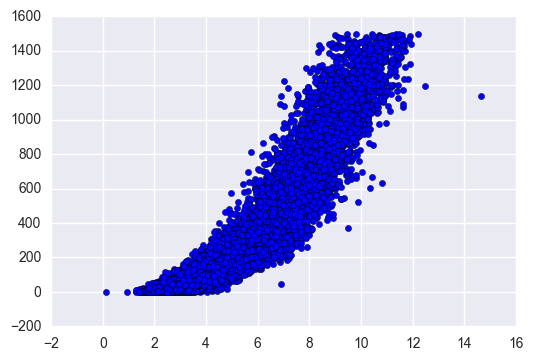

In [147]:
res = RF.predict(X_july)
xgbplt = pd.Series(res, index = list(X_july.speed))
#print(xgbplt)
#xgbplt.plot(title = "Validation")
plt.scatter(list(X_july.speed), y_test)

In [126]:
#Xgboost
import xgboost as xgb
from sklearn import cross_validation
X_dtrain, X_deval, y_dtrain, y_deval = cross_validation.train_test_split(X_train, y_train, random_state=1026, test_size=0.2)
dtrain = xgb.DMatrix(X_dtrain, y_dtrain)
deval = xgb.DMatrix(X_deval, y_deval)
watchlist = [(deval, 'eval')]
#param_grid = {'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1], 'min_child_weight': [0.3, 0.4, 0.5, 0.6, 1], 'max_depth':[2,3,4,5,6], 
#             'max_depth':[2,3,4,5,6], 'lambda':[0,0.1,1]}
params = {
    'booster': 'gbtree',
    'objective': 'reg:linear',
    'subsample': 0.6,##
    'min_child_weight': 0.3,##
    'colsample_bytree': 1,##
    'eta': 0.02,
    'max_depth': 3,
    'seed': 2016,
    'silent': 1,
    'alpha': 0,
    'eval_metric': 'rmse'
}
clf = xgb.train(params, dtrain, 500, watchlist, early_stopping_rounds=50)
pred = clf.predict(xgb.DMatrix(X_july))
print('Xgboost:', rmse(pred, list(y_test))/1500)

X_dtrain, X_deval, y_dtrain, y_deval = cross_validation.train_test_split(X_train, y_train3, random_state=1026, test_size=0.2)
dtrain = xgb.DMatrix(X_dtrain, y_dtrain)
deval = xgb.DMatrix(X_deval, y_deval)
watchlist = [(deval, 'eval')]
clf = xgb.train(params, dtrain, 500, watchlist, early_stopping_rounds=50)
pred = clf.predict(xgb.DMatrix(X_july))
print('Xgboost:', rmse3(pred, list(y_test))/1500)

[0]	eval-rmse:422.563
Will train until eval-rmse hasn't improved in 50 rounds.
[1]	eval-rmse:414.644
[2]	eval-rmse:406.914
[3]	eval-rmse:399.343
[4]	eval-rmse:391.909
[5]	eval-rmse:384.641
[6]	eval-rmse:377.528
[7]	eval-rmse:370.561
[8]	eval-rmse:363.736
[9]	eval-rmse:357.072
[10]	eval-rmse:350.522
[11]	eval-rmse:344.146
[12]	eval-rmse:337.905
[13]	eval-rmse:331.771
[14]	eval-rmse:325.797
[15]	eval-rmse:319.934
[16]	eval-rmse:314.199
[17]	eval-rmse:308.601
[18]	eval-rmse:303.13
[19]	eval-rmse:297.764
[20]	eval-rmse:292.536
[21]	eval-rmse:287.412
[22]	eval-rmse:282.41
[23]	eval-rmse:277.508
[24]	eval-rmse:272.725
[25]	eval-rmse:268.025
[26]	eval-rmse:263.425
[27]	eval-rmse:258.951
[28]	eval-rmse:254.57
[29]	eval-rmse:250.311
[30]	eval-rmse:246.13
[31]	eval-rmse:242.049
[32]	eval-rmse:238.055
[33]	eval-rmse:234.152
[34]	eval-rmse:230.335
[35]	eval-rmse:226.611
[36]	eval-rmse:222.982
[37]	eval-rmse:219.455
[38]	eval-rmse:215.996
[39]	eval-rmse:212.608
[40]	eval-rmse:209.302
[41]	eval-rmse

In [133]:
preddf = pd.read_csv('predictSpeed_ForPower.csv')

In [135]:
def rmse3(res_y, real_y):
    n = len(res_y)
    cnt = 0.0
    for i in range(n):
        cnt += (res_y[i]**3 - real_y[i])**2
    cnt /= n
    return math.sqrt(cnt)

In [136]:
preddf = preddf[preddf['status']==11]
#preddf = preddf[preddf['power'] >=0]
preddf = preddf[preddf['power'] <=1500]

In [137]:
X_pred = pd.DataFrame(preddf['speed'])
y_real = preddf['power']

In [138]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoLars, LassoCV, LassoLarsCV, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

##LinearRegression
LR = LinearRegression()
LR.fit(X_train,y_train)
print('LinearRegression:', rmse(LR.predict(X_pred), list(y_real))/1500)
LR.fit(X_train,y_train3)
print('LinearRegression:', rmse3(LR.predict(X_pred), list(y_real))/1500)

LinearRegression: 0.19964624328699188
LinearRegression: 0.183500114302632


In [139]:
#Ridge
RG = Ridge(alpha=2.0)
RG.fit(X_train,y_train)
print('Ridge:', rmse(RG.predict(X_pred), list(y_real))/1500)
RG.fit(X_train,y_train3)
print('Ridge:', rmse3(RG.predict(X_pred), list(y_real))/1500)

Ridge: 0.1996460358341872
Ridge: 0.183499993104256


In [140]:
#Lasso
LS = Lasso(alpha=10)
LS.fit(X_train,y_train)
print('Lasso:', rmse(LS.predict(X_pred), list(y_real))/1500)
LS.fit(X_train,y_train3)
print('Lasso:', rmse3(LS.predict(X_pred), list(y_real))/1500)

Lasso: 0.19872975529325299
Lasso: 0.21364427180863838


In [141]:
#RandomForest
RF = RandomForestRegressor()
RF.fit(X_train, y_train)
print('RandomForest:', rmse(RF.predict(X_pred), list(y_real))/1500)
RF.fit(X_train, y_train3)
print('RandomForest:', rmse3(RF.predict(X_pred), list(y_real))/1500)

RandomForest: 0.19203613383978727
RandomForest: 0.191858539946364


In [142]:
#Xgboost
import xgboost as xgb
from sklearn import cross_validation
X_dtrain, X_deval, y_dtrain, y_deval = cross_validation.train_test_split(X_train, y_train, random_state=1026, test_size=0.2)
dtrain = xgb.DMatrix(X_dtrain, y_dtrain)
deval = xgb.DMatrix(X_deval, y_deval)
watchlist = [(deval, 'eval')]
#param_grid = {'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1], 'min_child_weight': [0.3, 0.4, 0.5, 0.6, 1], 'max_depth':[2,3,4,5,6], 
#             'max_depth':[2,3,4,5,6], 'lambda':[0,0.1,1]}
params = {
    'booster': 'gbtree',
    'objective': 'reg:linear',
    'subsample': 0.6,##
    'min_child_weight': 0.3,##
    'colsample_bytree': 1,##
    'eta': 0.02,
    'max_depth': 3,
    'seed': 2016,
    'silent': 1,
    'alpha': 0,
    'eval_metric': 'rmse'
}
clf = xgb.train(params, dtrain, 500, watchlist, early_stopping_rounds=50)
pred = clf.predict(xgb.DMatrix(X_pred))
print('Xgboost:', rmse(pred, list(y_real))/1500)

X_dtrain, X_deval, y_dtrain, y_deval = cross_validation.train_test_split(X_train, y_train3, random_state=1026, test_size=0.2)
dtrain = xgb.DMatrix(X_dtrain, y_dtrain)
deval = xgb.DMatrix(X_deval, y_deval)
watchlist = [(deval, 'eval')]
clf = xgb.train(params, dtrain, 500, watchlist, early_stopping_rounds=50)
pred = clf.predict(xgb.DMatrix(X_pred))
print('Xgboost:', rmse3(pred, list(y_real))/1500)

[0]	eval-rmse:422.563
Will train until eval-rmse hasn't improved in 50 rounds.
[1]	eval-rmse:414.644
[2]	eval-rmse:406.914
[3]	eval-rmse:399.343
[4]	eval-rmse:391.909
[5]	eval-rmse:384.641
[6]	eval-rmse:377.528
[7]	eval-rmse:370.561
[8]	eval-rmse:363.736
[9]	eval-rmse:357.072
[10]	eval-rmse:350.522
[11]	eval-rmse:344.146
[12]	eval-rmse:337.905
[13]	eval-rmse:331.771
[14]	eval-rmse:325.797
[15]	eval-rmse:319.934
[16]	eval-rmse:314.199
[17]	eval-rmse:308.601
[18]	eval-rmse:303.13
[19]	eval-rmse:297.764
[20]	eval-rmse:292.536
[21]	eval-rmse:287.412
[22]	eval-rmse:282.41
[23]	eval-rmse:277.508
[24]	eval-rmse:272.725
[25]	eval-rmse:268.025
[26]	eval-rmse:263.425
[27]	eval-rmse:258.951
[28]	eval-rmse:254.57
[29]	eval-rmse:250.311
[30]	eval-rmse:246.13
[31]	eval-rmse:242.049
[32]	eval-rmse:238.055
[33]	eval-rmse:234.152
[34]	eval-rmse:230.335
[35]	eval-rmse:226.611
[36]	eval-rmse:222.982
[37]	eval-rmse:219.455
[38]	eval-rmse:215.996
[39]	eval-rmse:212.608
[40]	eval-rmse:209.302
[41]	eval-rmse

In [20]:
alphas = [0.01+i*0.01 for i in range(10)]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
print(cv_ridge)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()
print('Ridge:',cv_ridge.min())

NameError: name 'y' is not defined

In [23]:
import xgboost as xgb

regr = xgb.XGBRegressor(colsample_bytree=1, gamma=0.0, learning_rate=0.006, max_depth=2,min_child_weight=1,
                        n_estimators=7200, reg_alpha=0.9,reg_lambda=0.6,subsample=0.5,seed=42,silent=1)
regr.fit(X_train, y_train)
print(rmse(list(regr.predict(X_test)), list(y_test))/1500)

0.18538878905568573


In [95]:
import xgboost as xgb
from sklearn import cross_validation
X_dtrain, X_deval, y_dtrain, y_deval = cross_validation.train_test_split(X_train, y_train3, random_state=1026, test_size=0.2)
dtrain = xgb.DMatrix(X_dtrain, y_dtrain)
deval = xgb.DMatrix(X_deval, y_deval)
watchlist = [(deval, 'eval')]
param_grid = {'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1], 'min_child_weight': [0.3, 0.4, 0.5, 0.6, 1], 'max_depth':[2,3,4,5,6], 
             'max_depth':[2,3,4,5,6], 'lambda':[0,0.1,1]}


params = {
    'booster': 'gbtree',
    'objective': 'reg:linear',
    'subsample': 0.8,##
    'min_child_weight': 0.8,##
    'colsample_bytree': 1,##
    'eta': 0.02,
    'max_depth': 3,
    'seed': 2016,
    'silent': 1,
    'alpha': 0,
    'eval_metric': 'rmse'
}
clf = xgb.train(params, dtrain, 500, watchlist, early_stopping_rounds=50)
pred = clf.predict(xgb.DMatrix(X_pred))

[0]	eval-rmse:5.31927
Will train until eval-rmse hasn't improved in 50 rounds.
[1]	eval-rmse:5.21549
[2]	eval-rmse:5.11378
[3]	eval-rmse:5.01413
[4]	eval-rmse:4.9166
[5]	eval-rmse:4.82098
[6]	eval-rmse:4.72731
[7]	eval-rmse:4.6356
[8]	eval-rmse:4.54574
[9]	eval-rmse:4.45769
[10]	eval-rmse:4.37141
[11]	eval-rmse:4.28692
[12]	eval-rmse:4.20418
[13]	eval-rmse:4.12308
[14]	eval-rmse:4.04378
[15]	eval-rmse:3.96603
[16]	eval-rmse:3.88993
[17]	eval-rmse:3.81536
[18]	eval-rmse:3.74233
[19]	eval-rmse:3.67079
[20]	eval-rmse:3.60077
[21]	eval-rmse:3.5322
[22]	eval-rmse:3.46505
[23]	eval-rmse:3.39928
[24]	eval-rmse:3.33491
[25]	eval-rmse:3.27181
[26]	eval-rmse:3.21003
[27]	eval-rmse:3.14954
[28]	eval-rmse:3.09033
[29]	eval-rmse:3.03232
[30]	eval-rmse:2.97554
[31]	eval-rmse:2.92006
[32]	eval-rmse:2.8657
[33]	eval-rmse:2.81249
[34]	eval-rmse:2.76037
[35]	eval-rmse:2.70944
[36]	eval-rmse:2.65957
[37]	eval-rmse:2.61085
[38]	eval-rmse:2.56308
[39]	eval-rmse:2.51631
[40]	eval-rmse:2.4706
[41]	eval-rmse:

In [96]:
print('Xgboost:', rmse3(list(pred), list(y_real))/1500)

Xgboost: 0.1844200361123284


In [516]:
import xgboost as xgb
from sklearn import cross_validation

from sklearn.model_selection import GridSearchCV

param_grid = {'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1], 'min_child_weight': [0.3, 0.4, 0.5, 0.6, 1], 'max_depth':[2,3,4,5,6]}
svr = xgb.XGBRegressor(objective='reg:linear', learning_rate=0.1,
    reg_alpha=0,reg_lambda=0.6, seed=42,silent=1)
clf = GridSearchCV(svr, param_grid)
clf.fit(pd.DataFrame(df_valid['speed']), df_valid['power'])
xgb.XGBRegressor()

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [517]:
print(clf.best_params_)

{'min_child_weight': 0.3, 'max_depth': 3, 'subsample': 0.6}


In [610]:
pred = clf.predict(xgb.DMatrix(speed_pree))

In [ ]:
import xgboost as xgb
from sklearn import cross_validation
X_dtrain, X_deval, y_dtrain, y_deval = cross_validation.train_test_split(X_train, y_train, random_state=1026, test_size=0.2)
dtrain = xgb.DMatrix(X_dtrain, y_dtrain)
deval = xgb.DMatrix(X_deval, y_deval)
watchlist = [(deval, 'eval')]
#param_grid = {'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1], 'min_child_weight': [0.3, 0.4, 0.5, 0.6, 1],
#              'max_depth':[2,3,4,5,6], 'lambda':[0,0.1,1]}
param_grid = {'subsample': [0.6,0.8], 'min_child_weight': [0.4,0.5,0.6,0.7,0.8,0.9,1],
              'max_depth':[2], 'lambda':[0,0.1]}
resultstr=[]
for sub in param_grid['subsample']:
    for min_child in param_grid['min_child_weight']:
        for max_d in param_grid['max_depth']:
            for lam in param_grid['lambda']:  
                params = {
                    'booster': 'gbtree',
                    'objective': 'reg:linear',
                    'subsample': sub,
                    'min_child_weight': min_child,
                    'colsample_bytree': 1,
                    'eta': 0.1,
                    'max_depth': max_d,
                    'seed': 2016,
                    'silent': 1,
                    'alpha': 0,
                    'lambda': lam,
                    'eval_metric': 'rmse'
                }
                clf = xgb.train(params, dtrain, 500, watchlist, early_stopping_rounds=50)
                pred = clf.predict(xgb.DMatrix(speed_pree))
                resultstr.append('sub:'+str(sub)+',min_child:'+str(min_child)+',max_d:'+str(max_d)+',lam:'+str(lam))
                resultstr.append(rmse(list(pred), list(powerr))/1500)

[0]	eval-rmse:391.564
Will train until eval-rmse hasn't improved in 50 rounds.
[1]	eval-rmse:356.328
[2]	eval-rmse:324.934
[3]	eval-rmse:296.997
[4]	eval-rmse:272.14
[5]	eval-rmse:249.68
[6]	eval-rmse:229.774
[7]	eval-rmse:212.327
[8]	eval-rmse:196.736
[9]	eval-rmse:183.085
[10]	eval-rmse:171.068
[11]	eval-rmse:160.556
[12]	eval-rmse:151.477
[13]	eval-rmse:143.365
[14]	eval-rmse:136.429
[15]	eval-rmse:130.516
[16]	eval-rmse:125.422
[17]	eval-rmse:121.18
[18]	eval-rmse:117.442
[19]	eval-rmse:114.329
[20]	eval-rmse:111.666
[21]	eval-rmse:109.434
[22]	eval-rmse:107.571
[23]	eval-rmse:105.921
[24]	eval-rmse:104.629
[25]	eval-rmse:103.483
[26]	eval-rmse:102.559
[27]	eval-rmse:101.741
[28]	eval-rmse:101.074
[29]	eval-rmse:100.536
[30]	eval-rmse:100.071
[31]	eval-rmse:99.6969
[32]	eval-rmse:99.3778
[33]	eval-rmse:99.1201
[34]	eval-rmse:98.8873
[35]	eval-rmse:98.7069
[36]	eval-rmse:98.5563
[37]	eval-rmse:98.4322
[38]	eval-rmse:98.331
[39]	eval-rmse:98.2313
[40]	eval-rmse:98.1571
[41]	eval-rmse